In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import pickle as pkl
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import mplfinance as mpf

In [2]:
ANALYSED_DATA = 200
PREDICTED_DATA = 10

In [3]:
df = pd.read_csv("BTCUSDT_1.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index("datetime", inplace=True)
df

,open,high,low,close,volume
datetime,,,,,
2023-12-20 11:51:00,42780.57,42809.98,42776.38,42802.18,2.671363
2023-12-20 11:52:00,42802.18,42814.00,42802.18,42803.96,0.672444
2023-12-20 11:53:00,42803.96,42806.69,42794.08,42796.88,0.235994
2023-12-20 11:54:00,42796.88,42814.90,42793.91,42793.91,2.819273
2023-12-20 11:55:00,42793.91,42808.91,42790.91,42808.90,2.570392
...,...,...,...,...,...
2024-12-17 19:17:00,106949.60,106991.67,106892.96,106922.62,34.042969
2024-12-17 19:18:00,106922.62,106930.35,106743.81,106752.56,40.524759
2024-12-17 19:19:00,106752.56,106768.54,106648.20,106736.50,30.416048


In [4]:
df2 = pd.DataFrame(columns=["open", "high", "low", "close", "volume"])

In [5]:
# находим разности (для всего кроме volume)
for i in tqdm(range(1, 523171)):
    df2.loc[i-1] = [df.iloc[i]['open'] - df.iloc[i-1]['open'], df.iloc[i]['high'] - df.iloc[i-1]['high'], \
                            df.iloc[i]['low'] - df.iloc[i-1]['low'], df.iloc[i]['close'] - df.iloc[i-1]['close'], df.iloc[i]['volume']]
df2

 20%|██        | 106744/523170 [02:34<10:01, 692.27it/s]


KeyboardInterrupt: 

In [16]:
df2.to_csv("df_differences.csv")

In [6]:
df2 = pd.read_csv("df_differences.csv")
df2 = df2.drop(columns=["Unnamed: 0"])
df2

,open,high,low,close,volume
0,21.61,4.02,25.80,1.78,0.672444
1,1.78,-7.31,-8.10,-7.08,0.235994
2,-7.08,8.21,-0.17,-2.97,2.819273
3,-2.97,-5.99,-3.00,14.99,2.570392
4,14.99,9.75,17.99,6.01,2.748969
...,...,...,...,...,...
523165,-126.88,-100.85,-21.36,-26.98,34.042969
523166,-26.98,-61.32,-149.15,-170.06,40.524759
523167,-170.06,-161.81,-95.61,-16.06,30.416048
523168,-16.06,87.96,53.08,85.89,30.169778


In [7]:
columns = df.columns
def create_dataset(data: pd.DataFrame, x_size: int, y_size: int):
    X, y = [], []
    for i in tqdm(range(x_size, data.shape[0] - y_size)):
        X.append(data.iloc[i - x_size:i][columns].to_numpy())
        y.append(data.iloc[i:i+y_size][columns].to_numpy())
    X = np.array(X)
    y = np.array(y)
    y = y.reshape((y.shape[0], y.shape[1]*y.shape[2]))
    return X, y

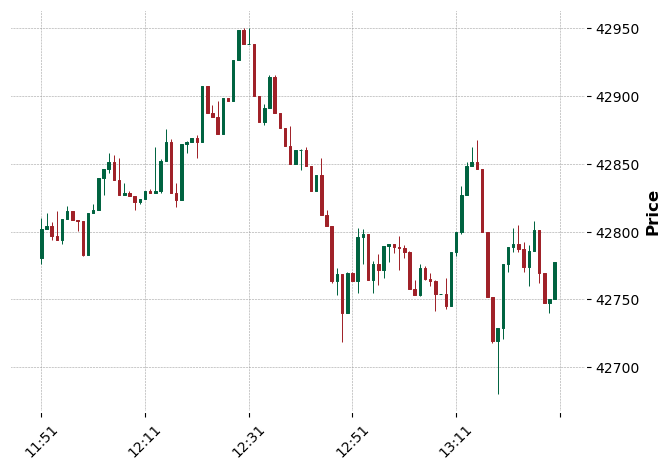

In [8]:
#df_train,  df_test = train_test_split(df2, test_size=0.15)
df_train,  df_test = train_test_split(df, test_size=0.15, shuffle=False)
mpf.plot(df_train[:100], type="candle", style="charles")


In [9]:
scaler = MinMaxScaler()
df_train = scaler.fit_transform(df_train)
df_train = pd.DataFrame(df_train, columns=columns)
#pd.DataFrame(scaler.inverse_transform(df_train))

In [10]:
with open("scaler_without_diff.pkl", "wb") as f:
    pkl.dump(scaler, f)

In [12]:
X_train, y_train = create_dataset(df_train, ANALYSED_DATA, PREDICTED_DATA)

100%|██████████| 444485/444485 [01:29<00:00, 4988.55it/s]


In [16]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=X_train.shape[-2:]))
model.add(LSTM(32, return_sequences=False, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[-1]))

optimizer = keras.optimizers.Adam()
model.compile(loss = "mae", optimizer=optimizer, metrics=[keras.metrics.MeanSquaredError(), keras.metrics.RootMeanSquaredError()])
print(model.summary())


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 200, 64)        │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         1,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,986 (124.95 KB)

 Trainable params: 31,986 (124.95 KB)

 Non-trainable params: 0 (0.00 B)

None


In [14]:
EPOCHS = 1

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=EPOCHS, shuffle=False)

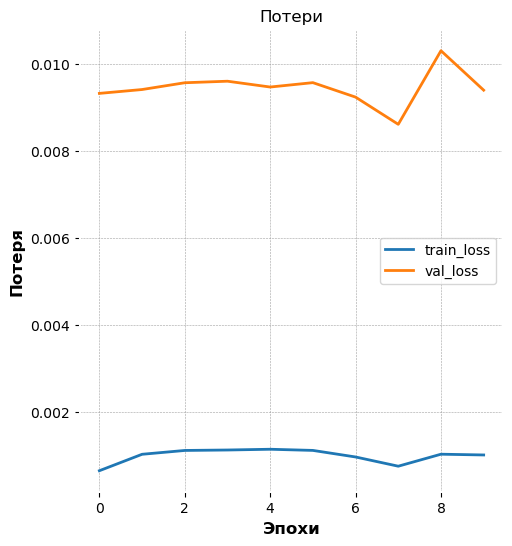

In [49]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Потери')
plt.xlabel('Эпохи')
plt.ylabel('Потеря')
plt.legend()


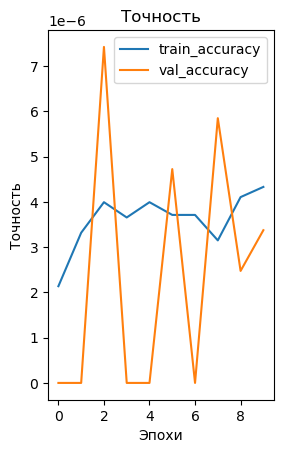

In [18]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Точность')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()

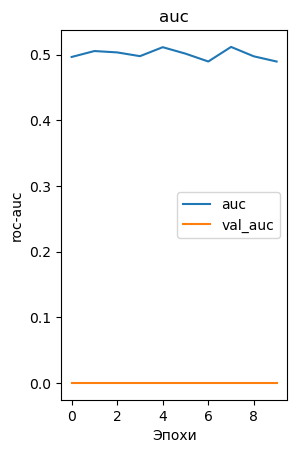

In [19]:
plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.title('auc')
plt.xlabel('Эпохи')
plt.ylabel('roc-auc')
plt.legend()

In [52]:
tm = scaler.inverse_transform(X_train[0])
tm = pd.DataFrame(tm, columns=["Open", "High", "Low", "Close", "Volume"])

,Open,High,Low,Close,Volume
0,42780.57,42809.98,42776.38,42802.18,2.671363
1,42802.18,42814.00,42802.18,42803.96,0.672444
2,42803.96,42806.69,42794.08,42796.88,0.235994
3,42796.88,42814.90,42793.91,42793.91,2.819273
4,42793.91,42808.91,42790.91,42808.90,2.570392
...,...,...,...,...,...
195,42876.69,42876.69,42839.06,42842.76,6.563540
196,42842.76,42844.11,42822.00,42826.00,2.789057
197,42826.00,42826.00,42800.86,42802.91,3.830839
198,42802.91,42813.00,42780.36,42780.36,35.748465


In [51]:
mpf.plot(tm, style="charles")

TypeError: Expect data.index as DatetimeIndex